<a href="https://colab.research.google.com/github/HyeongChanHam/Lung_Cancer_detection/blob/master/U_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import numpy as np
import random
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.io import imread, imshow

from tqdm import tqdm

from skimage.transform import resize

In [30]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
PATH = "gdrive/My Drive/lung_cancer/"

In [0]:
img_path = PATH+'image/'
label_path = PATH+'mask/'

In [34]:
img_ids = next(os.walk(img_path))[2]
label_ids = next(os.walk(label_path))[2]
img_ids.sort()
label_ids.sort()
len(img_ids)

1169

In [0]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1

In [35]:
X_train = np.zeros((len(img_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(img_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(img_ids), total=len(img_ids)):
    path = img_path + id_
    img = np.expand_dims(imread(path),axis=2)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img

for n, id_ in tqdm(enumerate(label_ids), total=len(label_ids)):
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
    path = label_path + id_
    label = np.expand_dims(imread(path), axis=2)
    mask = resize(label, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    Y_train[n] = mask


Getting and resizing train images and masks ... 



100%|██████████| 1169/1169 [15:17<00:00,  1.27it/s]

100%|██████████| 1167/1167 [18:45<00:00,  1.04it/s]


image_LIDC-IDRI-0003_0_6.png


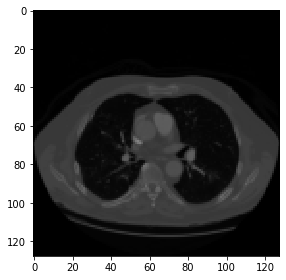

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


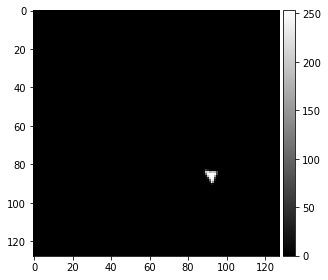

In [37]:
ix = random.randint(0, len(img_ids))
print(img_ids[ix])
imshow(X_train[ix][:,:,0])
plt.show()
imshow(Y_train[ix][:,:,0],cmap=plt.cm.gray)
plt.show()

In [38]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint


inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy')

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 128, 128, 1)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 128, 128, 16) 160         lambda_5[0][0]                   
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 128, 128, 16) 0           conv2d_77[0][0]                  
____________________________________________________________________________________________

In [39]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Train on 1052 samples, validate on 117 samples
Epoch 1/50
1052/1052 [==============================] - 188s 178ms/step - loss: 627.0881 - val_loss: 1.6682

Epoch 00001: val_loss improved from inf to 1.66819, saving model to model-dsbowl2018-1.h5
Epoch 2/50
1052/1052 [==============================] - 188s 179ms/step - loss: 0.8903 - val_loss: 0.3989

Epoch 00002: val_loss improved from 1.66819 to 0.39888, saving model to model-dsbowl2018-1.h5
Epoch 3/50
1052/1052 [==============================] - 188s 178ms/step - loss: 0.4530 - val_loss: 0.3470

Epoch 00003: val_loss improved from 0.39888 to 0.34699, saving model to model-dsbowl2018-1.h5
Epoch 4/50
1052/1052 [==============================] - 185s 176ms/step - loss: 0.4220 - val_loss: 0.3316

Epoch 00004: val_loss improved from 0.34699 to 0.33162, saving model to model-dsbowl2018-1.h5
Epoch 5/50
1052/1052 [==============================] - 190s 180ms/step - loss: 0.3994 - val_loss: 0.3025

Epoch 00005: val_loss improved from 0.33162 

In [0]:
#model-dsbowl2018-1.h5 download
from google.colab import files
files.download('model-dsbowl2018-1.h5')

In [42]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5')
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

117/117 [==============================] - 5s 43ms/step


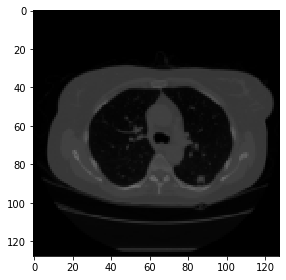

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


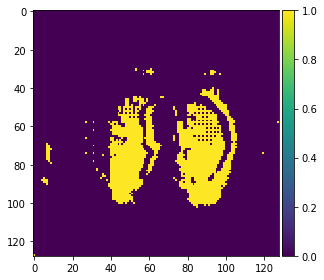

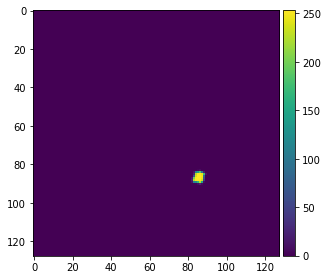

In [52]:
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix][:,:,0])
plt.show()
imshow(np.squeeze(preds_train_t[ix][:,:,0]))
plt.show()
imshow(np.squeeze(Y_train[ix][:,:,0]))
plt.show()